# 基于K线形态锤子线的趋势跟踪策略

---

### 1.基本原理

1.1 K线部位定义：  
    实体：某一根K线开盘价和收盘价之间部分;  
    上影线：某一根K线最高价到实体上端的部分;  
    下影线：某一根K线最低价到实体下端的部分;

1.2 锤子线定义  
   实体处于整个价格区间上端，实体颜色本身不影响;  
   下影线长度至少达到实体高度的2倍;  
   上影线很短;

1.3 策略原理  
在下跌过程中，当某一日出现锤子线，意味着当天行情先继续下跌后出现大幅反弹，行情可能由此反转; 
由此以观察期均线识别趋势下跌，以下跌趋势中出现锤子线作为开仓信号;  
采用移动止损方式进行止损构建此策略;

1.4 止损条件  
当天最低价 < max(均价-观察期内一定倍数的标准差，开仓价-开仓时标准差）;

<img src= "http://i1.bvimg.com/598810/8a06968def2dfb17.png" alt="锤子线" width="45%" align="left" border="4">

1.5 形态要点：    
在出现锤头线（锤子线）之前，股价需经过一段时间的下跌后，处于下跌趋势中，此时出现此形态才具有参考意义；  
锤头实体越小，下影线越长，止跌作用就越明显，参考价值越大；

## 2.策略回测结果

In [ ]:
%matplotlib inline
%run hammer.py

## 3.策略实现

### 3.1 收集并计算所需数据

In [1]:
import pandas as pd
import numpy as np
import tushare as ts

In [2]:
code = '002398'         # 股票代码
body_size = 0.03        # 表示锤子实体大小上限，基准为当日开盘价，实体不能太大，波动范围限制在3%；
head_size = 0.5         # 表示锤子上影线长度上限，基准为下影线长度，上影线要短一点，不能超过下影线的的一半；
tail_size = 2           # 表示下影线与实体大小比值，下影线要大于实体两倍；
length = 10             # 表示观察期时间长短；
stoplose_trigger = 1    # 表示当价格偏离均线满足几倍标准差时止损

In [3]:
data = ts.get_h_data(code, '2012-01-01', '2017-01-01')

[Getting data:]####################

In [4]:
data.sort_index(ascending=True, inplace=True)

In [5]:
data.head()

,open,high,close,low,volume,amount
date,,,,,,
2012-01-04,6.64,6.80,6.40,6.39,283430.0,4564127.0
2012-01-05,6.38,6.40,5.76,5.76,820954.0,12005136.0
2012-01-06,5.71,5.83,5.70,5.43,972637.0,13330505.0
2012-01-09,5.69,5.97,5.94,5.57,536522.0,7710121.0
2012-01-10,5.94,6.27,6.21,5.94,1121594.0,17023694.0


In [6]:
data.reset_index(inplace=True)        #把索引设置成为默认；为了后面交易策略逻辑循环更方便一些；

In [7]:
data.head()

,date,open,high,close,low,volume,amount
0,2012-01-04,6.64,6.80,6.40,6.39,283430.0,4564127.0
1,2012-01-05,6.38,6.40,5.76,5.76,820954.0,12005136.0
2,2012-01-06,5.71,5.83,5.70,5.43,972637.0,13330505.0
3,2012-01-09,5.69,5.97,5.94,5.57,536522.0,7710121.0
4,2012-01-10,5.94,6.27,6.21,5.94,1121594.0,17023694.0


In [8]:
data['pct_change'] = data['close'].pct_change()

In [9]:
data['ma'] = data['close'].rolling(length).mean()

In [10]:
data['std'] = data['close'].rolling(length).std()

In [11]:
del data['volume']
del data['amount']

In [13]:
data.tail()

,date,open,high,close,low,pct_change,ma,std
1188,2016-12-26,12.10,12.57,12.42,11.98,0.023908,12.141,0.161620
1189,2016-12-27,12.34,12.47,12.34,12.32,-0.006441,12.179,0.158986
1190,2016-12-28,12.34,12.45,12.38,12.31,0.003241,12.233,0.117289
1191,2016-12-29,12.41,12.59,12.49,12.27,0.008885,12.273,0.130559
1192,2016-12-30,12.41,12.55,12.50,12.27,0.000801,12.305,0.143778


由于实盘中当天的日线级别参考指标未实现，因此使用昨日参考指标指导当日交易,避免未来函数；

In [14]:
data['yes_ma'] = data['ma'].shift(1)          #昨天的mean和昨天的std；

In [15]:
data['yes_std'] = data['std'].shift(1)

### 3.2 识别锤子形态

计算实体，上影线，下影线

In [17]:
data['body'] = abs(data['open'] - data['close'])                   #计算K线实体；

In [18]:
data['head'] = data['high'] - data[['open', 'close']].max(axis = 1 )       #计算上影线，按行计算

In [19]:
data['tail'] = data[['open', 'close']].min(axis=1) - data['low']        #计算下影线

In [20]:
data.head()

,date,open,high,close,low,pct_change,ma,std,yes_ma,yes_std,body,head,tail
0,2012-01-04,6.64,6.80,6.40,6.39,NaN,NaN,NaN,NaN,NaN,0.24,0.16,0.01
1,2012-01-05,6.38,6.40,5.76,5.76,-0.100000,NaN,NaN,NaN,NaN,0.62,0.02,0.00
2,2012-01-06,5.71,5.83,5.70,5.43,-0.010417,NaN,NaN,NaN,NaN,0.01,0.12,0.27
3,2012-01-09,5.69,5.97,5.94,5.57,0.042105,NaN,NaN,NaN,NaN,0.25,0.03,0.12
4,2012-01-10,5.94,6.27,6.21,5.94,0.045455,NaN,NaN,NaN,NaN,0.27,0.06,0.00


判断K线各部分是否符合锤子线要求

In [21]:
data['body_cond'] = np.where(data['body']/data['open'] < body_size, 1, 0)     #实体的大小比开盘价要小于3%，K线实体不能太大；

In [22]:
data['head_cond'] = np.where(data['tail']==0, False, data['head'] / data['tail'] < head_size)   #上影线不能比下影线的一半长；
# 当尾部长度为0，为防止判断除法报错，两步判断；
# data['head_cond'] = np.where(data['head']/data['tail'] < head_size, 1, 0)   有可能tail = 0 

In [23]:
data['tail_cond'] = np.where(data['body']==0, True, (data['tail']/data['body']) > tail_size)    #下影线要比实体的两倍更长才满足条件；

In [24]:
data.head()

,date,open,high,close,low,pct_change,ma,std,yes_ma,yes_std,body,head,tail,body_cond,head_cond,tail_cond
0,2012-01-04,6.64,6.80,6.40,6.39,NaN,NaN,NaN,NaN,NaN,0.24,0.16,0.01,0,False,False
1,2012-01-05,6.38,6.40,5.76,5.76,-0.100000,NaN,NaN,NaN,NaN,0.62,0.02,0.00,0,False,False
2,2012-01-06,5.71,5.83,5.70,5.43,-0.010417,NaN,NaN,NaN,NaN,0.01,0.12,0.27,1,True,True
3,2012-01-09,5.69,5.97,5.94,5.57,0.042105,NaN,NaN,NaN,NaN,0.25,0.03,0.12,0,True,False
4,2012-01-10,5.94,6.27,6.21,5.94,0.045455,NaN,NaN,NaN,NaN,0.27,0.06,0.00,0,False,False


判断K线形态是否符合锤子线

In [25]:
data['hammer'] = data[['head_cond', 'body_cond', 'tail_cond']].all(axis=1)      #同时满足以上三个条件才是锤子K线；

In [27]:
data['hammer'].tail()

1188    False
1189    False
1190    False
1191    False
1192    False
Name: hammer, dtype: bool

In [28]:
data[data['hammer']].tail(10)

,date,open,high,close,low,pct_change,ma,std,yes_ma,yes_std,body,head,tail,body_cond,head_cond,tail_cond,hammer
1107,2016-08-24,12.08,12.09,12.06,11.99,0.002494,12.039,0.168091,12.031,0.168882,0.02,0.01,0.07,1,True,True,True
1111,2016-08-30,11.99,12.01,11.99,11.93,0.004188,12.038,0.109118,12.051,0.110499,0.00,0.02,0.06,1,True,True,True
1116,2016-09-06,12.29,12.35,12.34,12.10,0.007347,12.038,0.147558,12.007,0.102854,0.05,0.01,0.19,1,True,True,True
1129,2016-09-27,11.88,11.96,11.89,11.70,-0.000840,12.175,0.166483,12.242,0.173705,0.01,0.07,0.18,1,True,True,True
1136,2016-10-13,12.40,12.40,12.39,12.27,-0.000806,12.106,0.209772,12.098,0.198986,0.01,0.00,0.12,1,True,True,True
1140,2016-10-19,12.55,12.62,12.50,12.36,-0.001597,12.294,0.204407,12.234,0.224311,0.05,0.07,0.14,1,True,True,True
1144,2016-10-25,12.59,12.64,12.61,12.49,0.000000,12.482,0.098748,12.449,0.106087,0.02,0.03,0.10,1,True,True,True
1145,2016-10-26,12.60,12.63,12.62,12.46,0.000793,12.504,0.102870,12.482,0.098748,0.02,0.01,0.14,1,True,True,True
1167,2016-11-25,13.28,13.36,13.16,12.91,-0.009036,13.346,0.226137,13.333,0.241249,0.12,0.08,0.25,1,True,True,True
1179,2016-12-13,11.89,12.02,11.96,11.74,0.007582,12.556,0.348718,12.657,0.299742,0.07,0.06,0.15,1,True,True,True


由于实盘中当天的日线级别参考指标未实现，因此应根据昨日是否满足锤子形态要求作为开仓信号

In [29]:
data['yes_hammer'] = data['hammer'].shift(1)

### 3.3 编写交易逻辑——循环法

In [40]:
flag = 0    # 持仓记录，1代码有仓位，0代表空仓；
for i in range(2*length, len(data)):     #从20天开始计算，因为前期数据无效；
    # 如果已持仓，判断是否止损
    if flag == 1:
        stoplose_price = max(data.loc[i, 'yes_ma'] - stoplose_trigger*data.loc[i, 'yes_std'],
                             long_open_price-long_open_delta) 
        # 当天价格低于止损价，则进行止损，一个是移动止损，一个是开仓时候的开仓和开仓价-1倍标准差；
        if data.loc[i, 'low'] < stoplose_price:  #接下来要做的都是止损的操作；
            flag = 0
#             data.loc[i, 'return'] = min(data.loc[i, 'open'], stoplose_price)/data.loc[i-1, 'close'] - 1 
            #计算清盘当天的收益；取min是因为，如果当天开盘价就小于了止损价，那么我们就要以开盘价就止损；
            #不然会导致策略收益高估；
            #收益计算时要除以前一天的收盘价；
            data.loc[i, 'return'] = stoplose_price/data.loc[i-1, 'close'] - 1 
            
            data.loc[i, 'trade_mark'] = -10    # 表示当天持仓并进行平仓，记录自己当天交易操作，平仓：-10；
            #开仓是10；持仓为1，方便查阅；
        
        # 如果不满足止损条件，则继续持仓
        else:
            data.loc[i, 'return'] = data.loc[i, 'close']/data.loc[i-1, 'close'] - 1
            data.loc[i, 'trade_mark'] = 1    # 表示当天持仓



    # 如果未持仓，判断是否进行开仓
    else:
        # 判断是否为下降趋势，平均重心是下降的；锤子线开仓要满足形态和下降趋势；
        if data.loc[i-length, 'yes_ma'] > data.loc[i, 'yes_ma']:
            # 判断是否符合锤子形态
            if data.loc[i, 'yes_hammer']:
                # 更改持仓标记
                flag = 1
                # 记录开仓时开仓价格及标准差:是为了做固定止损；
                long_open_price = data.loc[i, 'open']
                long_open_delta = data.loc[i, 'yes_std']
                # 计算当天收益率
                data.loc[i, 'return'] = data.loc[i, 'close']/data.loc[i, 'open'] - 1  #以产生信号之后的第二天开盘价开仓；
                data.loc[i, 'trade_mark'] = 10    # 表示当天开仓
                # 当天开仓之后不进行平仓判断

In [41]:
data.tail(50)

,date,open,high,close,low,pct_change,ma,std,yes_ma,yes_std,...,tail,body_cond,head_cond,tail_cond,hammer,yes_hammer,return,trade_mark,strategy_return,stock_return
1143,2016-10-24,12.45,12.66,12.61,12.42,0.012851,12.449,0.106087,12.408,0.115739,...,0.03,1,False,False,False,False,0.012851,1.0,1.704319,1.970313
1144,2016-10-25,12.59,12.64,12.61,12.49,0.000000,12.482,0.098748,12.449,0.106087,...,0.10,1,True,True,True,False,0.000000,1.0,1.704319,1.970313
1145,2016-10-26,12.60,12.63,12.62,12.46,0.000793,12.504,0.102870,12.482,0.098748,...,0.14,1,True,True,True,True,0.000793,1.0,1.705671,1.971875
1146,2016-10-27,12.56,12.75,12.60,12.56,-0.001585,12.525,0.098347,12.504,0.102870,...,0.00,1,False,False,False,True,-0.001585,1.0,1.702968,1.968750
1147,2016-10-28,12.57,12.70,12.63,12.47,0.002381,12.547,0.094287,12.525,0.098347,...,0.10,1,False,False,False,False,0.002381,1.0,1.707022,1.973438
1148,2016-10-31,12.54,12.68,12.59,12.46,-0.003167,12.572,0.060332,12.547,0.094287,...,0.08,1,False,False,False,False,-0.003167,1.0,1.701616,1.967188
1149,2016-11-01,12.57,12.96,12.90,12.57,0.024623,12.610,0.117000,12.572,0.060332,...,0.00,1,False,False,False,False,0.024623,1.0,1.743515,2.015625
1150,2016-11-02,12.80,12.96,12.77,12.72,-0.010078,12.637,0.119912,12.610,0.117000,...,0.05,1,False,False,False,False,-0.010078,1.0,1.725944,1.995313
1151,2016-11-03,12.68,13.03,12.94,12.67,0.013312,12.672,0.151570,12.637,0.119912,...,0.01,1,False,False,False,False,0.013312,1.0,1.748921,2.021875
1152,2016-11-04,12.89,12.99,12.88,12.70,-0.004637,12.715,0.142302,12.672,0.151570,...,0.18,1,False,True,False,False,-0.004637,1.0,1.740812,2.012500


### 3.4 计算策略收益率

In [42]:
data['return'].fillna(0, inplace=True)                   #对大循环中未处理的：既没有持仓，也不满足开仓条件的日期进行处理，则让这些天的return都等于0；


data['strategy_return'] = (data['return'] + 1).cumprod()
data['stock_return'] = (data['pct_change'] + 1).cumprod()

### 3.5 绘图

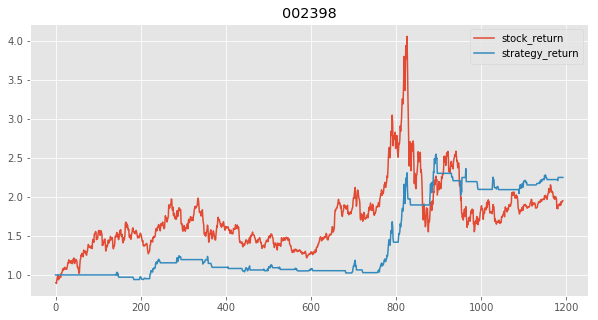

In [43]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.plot(data.stock_return)
ax.plot(data.strategy_return)
plt.title(code)
plt.legend()
plt.show()

#### 4. 策略改进和优化思考

1. 考虑成交量的配合：在锤子线后面的一根K线如果放量的话，交易信号更可信；    
2. 考虑跟其他形态的结合，例如锤子线后面紧跟着一根大阳线，交易信号更可信；  
3. 考虑和其他技术指标的结合，配合技术指标一起进行条件选股；

声明：本资料仅供内部学习交流使用，切勿外传。